<a href="https://colab.research.google.com/github/chan-98/single-cell-RNAseq-analysis/blob/main/scRNAseq_GSE171524_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524
The 29 CSV files provided in Supplementary table in GSE171524_RAW.tar folder was used.

In [1]:
!pip install scanpy scvi-tools doubletdetection celltypist hyperopt "ray[tune]" scikit-misc leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of orbax-checkpoint to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.2/503.2 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#The Dataset

*COVID-19 single-cell transcriptomic lung atlas*

**GSE171524**
 - Supplementary files - 29 samples

In [2]:
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171524/suppl/GSE171524_RAW.tar

--2025-04-25 16:51:39--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171524/suppl/GSE171524_RAW.tar
           => ‘GSE171524_RAW.tar’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE171nnn/GSE171524/suppl ... done.
==> SIZE GSE171524_RAW.tar ... 169728000
==> PASV ... done.    ==> RETR GSE171524_RAW.tar ... done.
Length: 169728000 (162M) (unauthoritative)

GSE171524_RAW.tar   100%[===================>] 161.87M  44.2MB/s    in 7.7s    

2025-04-25 16:51:48 (21.0 MB/s) - ‘GSE171524_RAW.tar’ saved [169728000]



In [3]:
!mkdir -p GSE171524_RAW && mv GSE171524_RAW.tar GSE171524_RAW/.
!cd GSE171524_RAW && tar -xf GSE171524_RAW.tar && rm GSE171524_RAW.tar && cd ../

In [4]:
import os
file_paths = ["GSE171524_RAW/" + f for f in os.listdir("GSE171524_RAW/")]
print(file_paths)

['GSE171524_RAW/GSM5226599_L21cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226575_C52ctr_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226590_L10cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226588_L08cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226586_L06cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226581_L01cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226592_L12cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226577_C54ctr_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226600_L22cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226598_L19cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226595_L16cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226594_L15cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226578_C55ctr_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226597_L18cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226579_C56ctr_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226593_L13cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226596_L17cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226583_L04cov_raw_counts.csv.gz', 'GSE171524_RAW/GSM5226574_C51ctr_raw_counts.c

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np

In [11]:
def load(fpath):
  """Load anndata and make new columns for sample metadata"""
  adata = sc.read_csv(fpath).T
  adata.obs["Sample"] = fpath.split("/")[1].split("_")[0]
  return adata

Performing analysis only on 2 of the count matrices due to RAM constraints

In [12]:
adatas = [load(x) for x in file_paths[:2]]  # Remove the [:2] for complete analysis
adatas

[AnnData object with n_obs × n_vars = 3425 × 34546
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 4513 × 34546
     obs: 'Sample']

In [13]:
adatas[1].obs.head(n=2)

,Sample
CATCGGGCAGCTCATA-1_2,GSM5226575
CACCAAAAGCCACAAG-1_2,GSM5226575


In [14]:
adatas[1].var

""
AL627309.1
AL627309.5
AL627309.4
AL669831.2
LINC01409
...
VN1R2
AL031676.1
SMIM34A
AL050402.1


In [15]:
adatas[1].X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# QC

Since the data is already UMI filtered matrix, we can skip the filtering part.

In [16]:
def qc(adata):
  sc.pp.filter_genes(adata, min_cells = 10)
  # Reducing dimensions to top 2000 genes only
  sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
  # Remove artifaacts and contaminants
  adata.var["mt"] = adata.var_names.str.startswith(("MT-", "mt-", "Mt-"))
  adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
  adata.var["hb"] = adata.var_names.str.startswith(("HB", "Dll"))
  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)
  remove_cols = ["total_counts_mt", "log1p_total_counts_mt", "total_counts_ribo",
                 "log1p_total_counts_ribo", "total_counts_hb", "log1p_total_counts_hb"]
  adata.obs.drop(columns=remove_cols, inplace=True)
  return adata

In [17]:
adatas = [qc(adata) for adata in adatas]
adatas

[AnnData object with n_obs × n_vars = 3425 × 2000
     obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'hvg',
 AnnData object with n_obs × n_vars = 4513 × 2000
     obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'hvg']

Means, Variances and Variances_norm are added when calculating highly variable genes.

In [19]:
adatas[1].var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
TTC34,11,True,948.0,0.003767,0.010846,1.692154,False,False,False,11,0.068223,0.065996,99.756260,307.889954,5.732985
KCNAB2,215,True,1713.0,0.070463,0.132002,1.375370,False,False,False,215,1.228066,0.801134,95.235985,5542.260254,8.620338
ERRFI1,1387,True,1676.0,0.735431,2.851087,1.387311,False,False,False,1387,25.429976,3.274499,69.266563,114765.445312,11.650655
SPSB1,688,True,1721.0,0.239309,0.573038,1.373204,False,False,False,688,9.597720,2.360639,84.755152,43314.503906,10.676266
KIF1B,1226,True,1591.0,0.482827,1.540541,1.413668,False,False,False,1226,13.510328,2.674861,72.834035,60972.082031,11.018188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IL6,65,True,1339.0,0.019942,0.035950,1.497468,False,False,False,65,0.824495,0.601303,98.559716,3720.945068,8.222002
CLEC5A,38,True,427.0,0.013517,0.035500,2.230772,False,False,False,38,0.314597,0.273530,99.157988,1419.776001,7.258958
MGAT4C,26,True,415.0,0.009085,0.024075,2.258210,False,False,False,26,0.544904,0.434961,99.423887,2459.149902,7.807978
AL133304.2,23,True,839.0,0.006426,0.013478,1.758373,False,False,False,23,0.181955,0.167169,99.490361,821.161011,6.711936


In [20]:
adatas[1].obs

,Sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb
CATCGGGCAGCTCATA-1_2,GSM5226575,710,6.566672,10000.000000,9.210441,27.307690,14.020976,2.989510,0.0
CACCAAAAGCCACAAG-1_2,GSM5226575,411,6.021023,10000.000000,9.210441,46.764204,15.672482,0.478334,0.0
CGAAGGACACTGGCCA-1_2,GSM5226575,586,6.375025,10000.000000,9.210441,32.481748,23.990269,0.340633,0.0
GTAGGTTTCAACTGAC-1_2,GSM5226575,363,5.897154,10000.000000,9.210441,35.740400,0.000000,0.000000,0.0
CTAACTTGTACACGCC-1_2,GSM5226575,563,6.335054,10000.000000,9.210441,36.754573,25.873131,0.213828,0.0
...,...,...,...,...,...,...,...,...,...
GATGATCTCCGCGGAT-1_2,GSM5226575,65,4.189655,10000.000000,9.210441,45.783135,0.000000,0.000000,0.0
TCTCACGAGCTGAAAT-1_2,GSM5226575,35,3.583519,10000.000000,9.210441,61.538462,0.000000,0.000000,0.0
ATGAAAGAGAGGCGGA-1_2,GSM5226575,43,3.784190,10000.000000,9.210441,68.918926,0.000000,0.000000,0.0
GATCAGTGTTTCGATG-1_2,GSM5226575,40,3.713572,10000.000000,9.210441,72.972979,0.000000,0.000000,0.0


In [21]:
df_adatas = pd.concat([adata.obs for adata in adatas])
df_adatas = df_adatas.sort_values("Sample")
df_adatas

,Sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb
CGCATAACACGCAAAG-1_2,GSM5226575,331,5.805135,10000.0,9.210441,29.405627,0.000000,0.000000,0.0
TATTGCTCACTAAACC-1_2,GSM5226575,105,4.663439,10000.0,9.210441,60.147607,0.000000,0.000000,0.0
CCCTAACGTGTCCCTT-1_2,GSM5226575,114,4.744932,10000.0,9.210441,47.727275,0.000000,0.000000,0.0
CAAAGAACATCGTTCC-1_2,GSM5226575,111,4.718499,10000.0,9.210441,44.607837,0.980392,0.000000,0.0
GATAGCTCAGGAATCG-1_2,GSM5226575,109,4.700480,10000.0,9.210441,47.783247,0.492611,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
GTATTGGAGTTCATCG-1_26,GSM5226599,57,4.060443,10000.0,9.210441,66.949155,0.000000,0.000000,0.0
TTTGGAGAGCGCCATC-1_26,GSM5226599,56,4.043051,10000.0,9.210441,67.272734,30.909094,0.909091,0.0
AGATGAATCTTCGGTC-1_26,GSM5226599,44,3.806662,10000.0,9.210441,56.363643,10.909091,3.636364,0.0
TAACTTCAGGATTTCC-1_26,GSM5226599,27,3.332205,10000.0,9.210441,81.081084,0.000000,0.000000,0.0


Plot MT, RIBO and HB counts, n_genes and other metrics per **sample**

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
#%matplotlib inline

In [26]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

def plotkde(df_adatas, value):
  sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
  g = sns.FacetGrid(df_adatas, row="Sample", hue="Sample", aspect=15, height=1.0, palette="tab20")

  g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
  g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2, alpha=1)
  g.map(plt.axhline, y=0, lw=2, clip_on=False)
  g.map(label, value)

  g.set_titles("")
  g.set(yticks=[])
  g.despine(bottom=True, left=True)

  for ax in g.axes.flat:
    ax.axvline(x=df_adatas[value].median(), color='r', linestyle='-')

  plt.show()

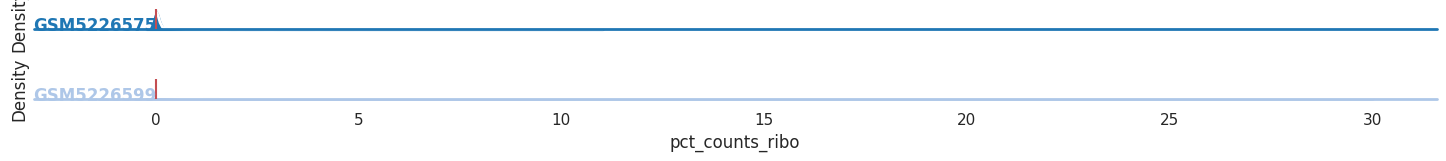

In [27]:
plotkde(df_adatas, "pct_counts_ribo")

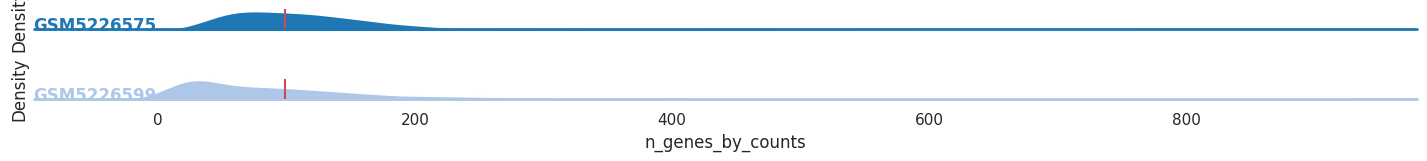

In [28]:
plotkde(df_adatas, "n_genes_by_counts")

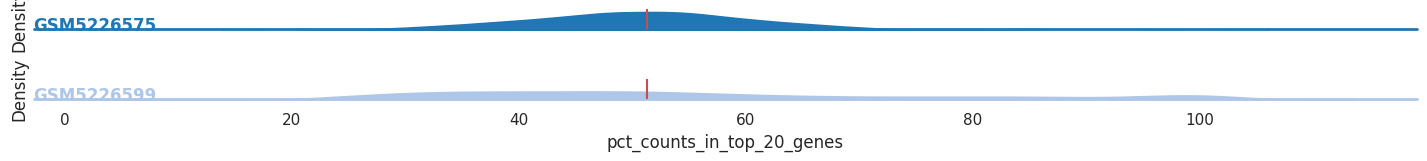

In [29]:
plotkde(df_adatas, "pct_counts_in_top_20_genes")

For unfiltered data, run the following code to filter outliers:

In [30]:
def filter_outliers(adata):
  sc.pp.filter_genes(adata, min_cells = 10)
  upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)    # upper_lim ~= 3000
  print(f"Upper limit is: {upper_lim}")
  sc.pp.filter_cells(adata, max_genes=upper_lim)
  adata = adata[adata.obs.pct_counts_mt < 20]
  adata = adata[adata.obs.pct_counts_ribo < 2]
  return adata

adatas = [filter_outliers(adata) for adata in adatas]

Upper limit is: 376.52
Upper limit is: 416.0


In [31]:
adatas[1].obs

,Sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,n_genes
CACCAAAAGCCACAAG-1_2,GSM5226575,411,6.021023,10000.000000,9.210441,46.764204,15.672482,0.478334,0.0,411
GTAGGTTTCAACTGAC-1_2,GSM5226575,363,5.897154,10000.000000,9.210441,35.740400,0.000000,0.000000,0.0,363
TAACCAGTCCGGCAGT-1_2,GSM5226575,285,5.655992,10000.000000,9.210441,46.955620,0.000000,0.103199,0.0,285
TGGTACATCGCCTATC-1_2,GSM5226575,338,5.826000,10000.000000,9.210441,43.243237,11.904763,0.643501,0.0,338
GGAGGTACAACCTATG-1_2,GSM5226575,353,5.869297,10000.000000,9.210441,42.619360,12.965398,0.438020,0.0,353
...,...,...,...,...,...,...,...,...,...,...
GATGATCTCCGCGGAT-1_2,GSM5226575,65,4.189655,10000.000000,9.210441,45.783135,0.000000,0.000000,0.0,65
TCTCACGAGCTGAAAT-1_2,GSM5226575,35,3.583519,10000.000000,9.210441,61.538462,0.000000,0.000000,0.0,35
ATGAAAGAGAGGCGGA-1_2,GSM5226575,43,3.784190,10000.000000,9.210441,68.918926,0.000000,0.000000,0.0,43
GATCAGTGTTTCGATG-1_2,GSM5226575,40,3.713572,10000.000000,9.210441,72.972979,0.000000,0.000000,0.0,40


# Normalization

Normalise every cell to 10,000 UMI (Standard, can be changed acc to data)


In [32]:
def norm(adata):
  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.log1p(adata)
  # Storing rawdata before modification
  adata.raw = adata
  sc.pp.filter_genes(adata, min_cells=10)
  return adata

In [33]:
adatas = [norm(adata) for adata in adatas]

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [34]:
adatas[0].X.sum(axis=1) # After normalisation

array([ 617.28296,  970.5813 , 1068.1039 , ...,  203.53595,  362.53534,
        384.8125 ], dtype=float32)

In [35]:
adatas[0].X

array([[0.       , 0.       , 0.       , ..., 4.4555836, 3.773983 ,
        3.1035366],
       [0.       , 4.2514076, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 3.0709338, 0.       , ..., 3.0709338, 3.0709338,
        3.740619 ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

# Clustering

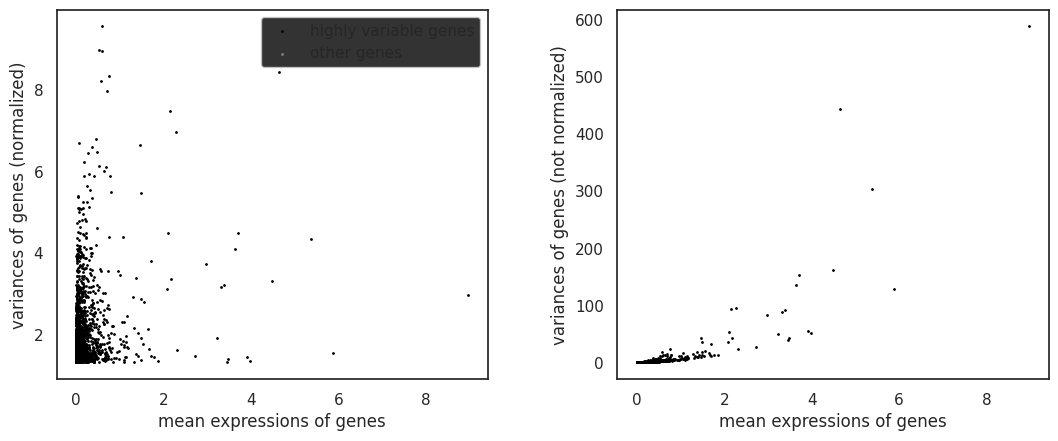

In [38]:
ad1 = adatas[1]
sc.pl.highly_variable_genes(ad1)

As it is already clustered and filtered data, only highly variable genes are present which are shown by black spots (other genes are generally shown as grey)

Now we have a set of 2000 genes. Further dimensionality reduction include:
- Regression
- Scaling (Normalization)
- Principal Component Analysis to reduce (by default - reduces to 50 PCs (50 genes))

And plot the 50 PCs to see how much they contribute to the variance.

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:648: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:648: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


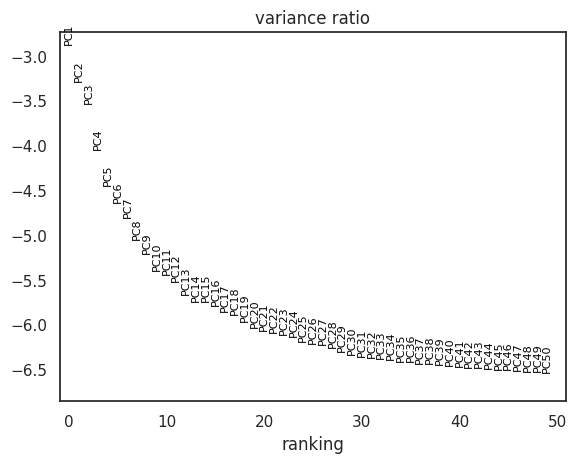

In [39]:
def dimreduce(adata):
  """
  Dimensionality reduction for single AnnData object
  """
  # Filtering out the genes which are not highly variable
  adata = adata[:, adata.var.highly_variable]
  # Eliminating differences arising due to sampling depth, mtRNA and ribosomal RNA
  sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])
  # Scaling (to normalise) each gene to the unit variance of the gene
  sc.pp.scale(adata, max_value=10)
  # PCA analysis (by default keeps top 50PCs)
  sc.tl.pca(adata, svd_solver='arpack')
  sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

ad1 = adatas[1].copy()
dimreduce(ad1)

Calculate the NEIGHBOURS of the top 30 PCs (distances). Neighbours denote similar cells, and similar cells will be clustered together.




In [40]:
sc.pp.neighbors(ad1, n_pcs = 30)

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 1913 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


In [41]:
ad1

AnnData object with n_obs × n_vars = 3970 × 1913
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_genes'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [42]:
ad1.obsp['connectivities']

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 81642 stored elements and shape (3970, 3970)>

In [43]:
ad1.obsp['distances'].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
ad1.obs

,Sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,n_genes
CACCAAAAGCCACAAG-1_2,GSM5226575,411,6.021023,10000.000000,9.210441,46.764204,15.672482,0.478334,0.0,411
GTAGGTTTCAACTGAC-1_2,GSM5226575,363,5.897154,10000.000000,9.210441,35.740400,0.000000,0.000000,0.0,363
TAACCAGTCCGGCAGT-1_2,GSM5226575,285,5.655992,10000.000000,9.210441,46.955620,0.000000,0.103199,0.0,285
TGGTACATCGCCTATC-1_2,GSM5226575,338,5.826000,10000.000000,9.210441,43.243237,11.904763,0.643501,0.0,338
GGAGGTACAACCTATG-1_2,GSM5226575,353,5.869297,10000.000000,9.210441,42.619360,12.965398,0.438020,0.0,353
...,...,...,...,...,...,...,...,...,...,...
GATGATCTCCGCGGAT-1_2,GSM5226575,65,4.189655,10000.000000,9.210441,45.783135,0.000000,0.000000,0.0,65
TCTCACGAGCTGAAAT-1_2,GSM5226575,35,3.583519,10000.000000,9.210441,61.538462,0.000000,0.000000,0.0,35
ATGAAAGAGAGGCGGA-1_2,GSM5226575,43,3.784190,10000.000000,9.210441,68.918926,0.000000,0.000000,0.0,43
GATCAGTGTTTCGATG-1_2,GSM5226575,40,3.713572,10000.000000,9.210441,72.972979,0.000000,0.000000,0.0,40


Convert the 30 dimensions to 2 dimensions using UMAP clustering based on connectivities and distances.

In [45]:
sc.pp.neighbors(ad1, n_pcs = 30)

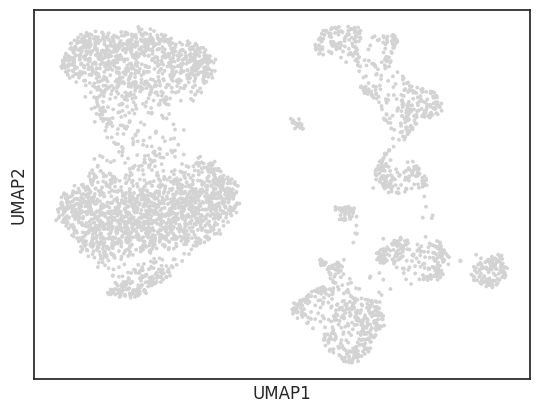

In [46]:
sc.tl.umap(ad1)
sc.pl.umap(ad1)

Assign colours and annotate each cluster.

Resolution closer to 1 gives more clusters, closer to 0 gives fewer clusters, start with 0.5 and adjust accordingly.

In [47]:
sc.tl.leiden(ad1, resolution = 0.5)

<ipython-input-47-c6c97a80f8af>:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ad1, resolution = 0.5)


In [48]:
ad1.obs

,Sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,n_genes,leiden
CACCAAAAGCCACAAG-1_2,GSM5226575,411,6.021023,10000.000000,9.210441,46.764204,15.672482,0.478334,0.0,411,7
GTAGGTTTCAACTGAC-1_2,GSM5226575,363,5.897154,10000.000000,9.210441,35.740400,0.000000,0.000000,0.0,363,2
TAACCAGTCCGGCAGT-1_2,GSM5226575,285,5.655992,10000.000000,9.210441,46.955620,0.000000,0.103199,0.0,285,2
TGGTACATCGCCTATC-1_2,GSM5226575,338,5.826000,10000.000000,9.210441,43.243237,11.904763,0.643501,0.0,338,8
GGAGGTACAACCTATG-1_2,GSM5226575,353,5.869297,10000.000000,9.210441,42.619360,12.965398,0.438020,0.0,353,7
...,...,...,...,...,...,...,...,...,...,...,...
GATGATCTCCGCGGAT-1_2,GSM5226575,65,4.189655,10000.000000,9.210441,45.783135,0.000000,0.000000,0.0,65,3
TCTCACGAGCTGAAAT-1_2,GSM5226575,35,3.583519,10000.000000,9.210441,61.538462,0.000000,0.000000,0.0,35,1
ATGAAAGAGAGGCGGA-1_2,GSM5226575,43,3.784190,10000.000000,9.210441,68.918926,0.000000,0.000000,0.0,43,0
GATCAGTGTTTCGATG-1_2,GSM5226575,40,3.713572,10000.000000,9.210441,72.972979,0.000000,0.000000,0.0,40,0


Replot the UMAP based on the col `leiden`

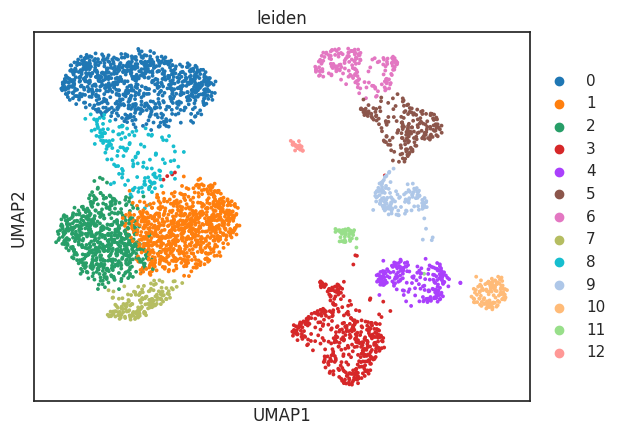

In [49]:
sc.pl.umap(ad1, color=['leiden'])

This data will be annotated using `celltypist`

---------
Clustering for ALL `adatas` (integrated)

In [50]:
"""For all adata objects (adatas)"""

adata_combined = sc.concat(adatas)
adata_combined

AnnData object with n_obs × n_vars = 6257 × 867
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_genes'

In [51]:
adata_combined.X

array([[0.       , 3.1035366, 0.       , ..., 4.4555836, 3.773983 ,
        3.1035366],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 2.0610242, 0.       , ..., 3.0709338, 3.0709338,
        3.740619 ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

This is a dense matrix - consumes more memory, and has actual physical values for each entry.

If our data was not already 2 dimensional and processed, we would have to convert it to sparse matrix.

In [52]:
from scipy.sparse import csr_matrix

In [53]:
adata_combined.X = csr_matrix(adata_combined.X)
adata_combined.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 378306 stored elements and shape (6257, 867)>

In [54]:
adata_combined.write_h5ad('combined.h5ad') # Save

In [55]:
# adata_combined = sc.read_h5ad('combined.h5ad')

adata_combined.obs.groupby("Sample").count()

<ipython-input-55-4a31b7bb9e35>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_combined.obs.groupby("Sample").count()


,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,n_genes
Sample,,,,,,,,,
GSM5226575,3970,3970,3970,3970,3970,3970,3970,3970,3970
GSM5226599,2287,2287,2287,2287,2287,2287,2287,2287,2287


If the dimension ( `n_vars` ) was too high (in thousands or tens of thousands instead of 2), do the following to reduce dims:

In [56]:
sc.pp.filter_genes(adata_combined, min_cells = 100)

Now we need to correct for batch effects using regression, scaling and perform PCA analysis

In [57]:
import scvi

/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [59]:
def dimreduce(adata):
  """
  Clustering for all adata objects combined
  """
  # Save the counts
  adata.layers['counts'] = adata.X.copy()
  print("Normalising raw counts")
  sc.pp.normalize_total(adata, target_sum = 1e4)
  sc.pp.log1p(adata)
  adata.raw = adata
  print(f"This is what data looks like: {adata.obs.head(n=2)}")
  print("Fetching highly variable genes (top 2000)")
  sc.pp.highly_variable_genes(adata, n_top_genes=2000,
                              subset = True, layer = 'counts',
                              flavor = "seurat_v3", batch_key="Sample") # provide batch_key for combined adata
  print("Setting up SCVI model")
  scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])
  model = scvi.model.SCVI(adata)
  print("Training model")
  model.train()
  print(f"Trained SCVI model (np array) looks like: f{model.get_latent_representation().shape}")
  print("Computing X_scVI")
  # Save the model
  adata.obsm["X_scVI"] = model.get_latent_representation()
  # Add layer for normalized values
  adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)
  print("Calculating neighbours using SCVI results")
  sc.pp.neighbors(adata, use_rep = 'X_scVI') # gives distances and connectivities
  print("UMAP clustering")
  sc.tl.umap(adata)
  sc.tl.leiden(adata, resolution = 0.5)
  #sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)
  print("Done")
  return adata

integrated_adata = dimreduce(adata_combined)

Normalising raw counts


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


This is what data looks like:                            Sample  n_genes_by_counts  log1p_n_genes_by_counts  \
CAGCAGCGTTGCTGAT-1_26  GSM5226599                166                 5.117994   
CCACGAGAGGCATGCA-1_26  GSM5226599                305                 5.723585   

                       total_counts  log1p_total_counts  \
CAGCAGCGTTGCTGAT-1_26       10000.0            9.210441   
CCACGAGAGGCATGCA-1_26       10000.0            9.210441   

                       pct_counts_in_top_20_genes  pct_counts_mt  \
CAGCAGCGTTGCTGAT-1_26                   47.234043      14.468086   
CCACGAGAGGCATGCA-1_26                   26.297581       0.000000   

                       pct_counts_ribo  pct_counts_hb  n_genes  _scvi_batch  \
CAGCAGCGTTGCTGAT-1_26          0.00000            0.0      166            0   
CCACGAGAGGCATGCA-1_26          0.11534            0.0      305            0   

                       _scvi_labels  
CAGCAGCGTTGCTGAT-1_26             0  
CCACGAGAGGCATGCA-1_26        

Training:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the 

Trained SCVI model (np array) looks like: f(6257, 10)
Computing X_scVI
Calculating neighbours using SCVI results
UMAP clustering
Done


In [63]:
integrated_adata.write_h5ad('integrated.h5ad')

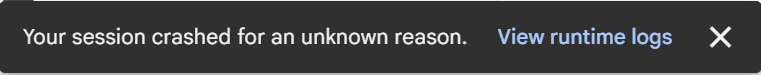

***Note: May fail due to limited compute resources, try again, or proceed with `ad1`***

# Cell Typist for Cluster Annotation

In [64]:
import celltypist
from celltypist import models

Looking at available models for cell type classification.

Documentation provided at https://github.com/Teichlab/celltypist is followed for processing and plotting.

In [61]:
models.get_all_models()

['Adult_Human_PancreaticIslet.pkl',
 'Adult_Human_PrefrontalCortex.pkl',
 'COVID19_HumanChallenge_Blood.pkl',
 'Nuclei_Lung_Airway.pkl',
 'Fetal_Human_AdrenalGlands.pkl',
 'Cells_Human_Tonsil.pkl',
 'Healthy_COVID19_PBMC.pkl',
 'Adult_CynomolgusMacaque_Hippocampus.pkl',
 'Mouse_Isocortex_Hippocampus.pkl',
 'Human_Embryonic_YolkSac.pkl',
 'Cells_Fetal_Lung.pkl',
 'Developing_Human_Gonads.pkl',
 'Developing_Human_Thymus.pkl',
 'Developing_Human_Brain.pkl',
 'Healthy_Human_Liver.pkl',
 'Adult_Pig_Hippocampus.pkl',
 'Human_Colorectal_Cancer.pkl',
 'Adult_Human_Vascular.pkl',
 'Fetal_Human_Skin.pkl',
 'Cells_Lung_Airway.pkl',
 'Mouse_Postnatal_DentateGyrus.pkl',
 'Adult_Mouse_OlfactoryBulb.pkl',
 'Human_Longitudinal_Hippocampus.pkl',
 'Fetal_Human_Pituitary.pkl',
 'Developing_Human_Hippocampus.pkl',
 'Human_Lung_Atlas.pkl',
 'Adult_Human_Skin.pkl',
 'Adult_COVID19_PBMC.pkl',
 'Healthy_Adult_Heart.pkl',
 'Healthy_Mouse_Liver.pkl',
 'Developing_Mouse_Brain.pkl',
 'Human_Placenta_Decidua.pkl',

In [65]:
model_pancreas = models.Model.load(model="Human_Lung_Atlas.pkl")

In [66]:
integrated_adata.obs.head(n=3)

,Sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,n_genes,_scvi_batch,_scvi_labels,leiden
CAGCAGCGTTGCTGAT-1_26,GSM5226599,166,5.117994,10000.0,9.210441,47.234043,14.468086,0.000000,0.0,166,0,0,3
CCACGAGAGGCATGCA-1_26,GSM5226599,305,5.723585,10000.0,9.210441,26.297581,0.000000,0.115340,0.0,305,0,0,0
TCAGTTTGTTAGGAGC-1_26,GSM5226599,374,5.926926,10000.0,9.210441,32.350923,14.461960,1.233722,0.0,374,0,0,0


Select model: Human Lung Atlas

In [70]:
def predict_cells(adata):
  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.log1p(adata)
  #sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)
  #adata.X = adata.X.toarray()

  predictions = celltypist.annotate(adata, model=model_pancreas, majority_voting=False)
  predictions_adata = predictions.to_adata()
  adata.obs["lung_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
  adata.obs["lung_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

  return adata

In [71]:
predictions = predict_cells(integrated_adata.copy())

In [72]:
predictions.obs.head(n=3)

,Sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,n_genes,_scvi_batch,_scvi_labels,leiden,predicted_labels,conf_score,lung_label,lung_score
CAGCAGCGTTGCTGAT-1_26,GSM5226599,166,5.117994,10000.0,9.210441,47.234043,14.468086,0.000000,0.0,166,0,0,3,Monocyte-derived Mph,0.212574,Monocyte-derived Mph,0.212574
CCACGAGAGGCATGCA-1_26,GSM5226599,305,5.723585,10000.0,9.210441,26.297581,0.000000,0.115340,0.0,305,0,0,0,Smooth muscle,0.015589,Smooth muscle,0.015589
TCAGTTTGTTAGGAGC-1_26,GSM5226599,374,5.926926,10000.0,9.210441,32.350923,14.461960,1.233722,0.0,374,0,0,0,AT2,0.318151,AT2,0.318151


In [73]:
predictions.obs["Sample"].unique()

['GSM5226599', 'GSM5226575']
Categories (2, object): ['GSM5226575', 'GSM5226599']

In [74]:
predictions.obs.to_csv('PREDICTIONS_GSM5226575_GSM5226599.csv')

In [75]:
predictions.obs["conf_score"].describe()

,conf_score
count,6257.000000
mean,0.126347
std,0.226190
min,0.000362
25%,0.004428
50%,0.018999
75%,0.120014
max,0.994879


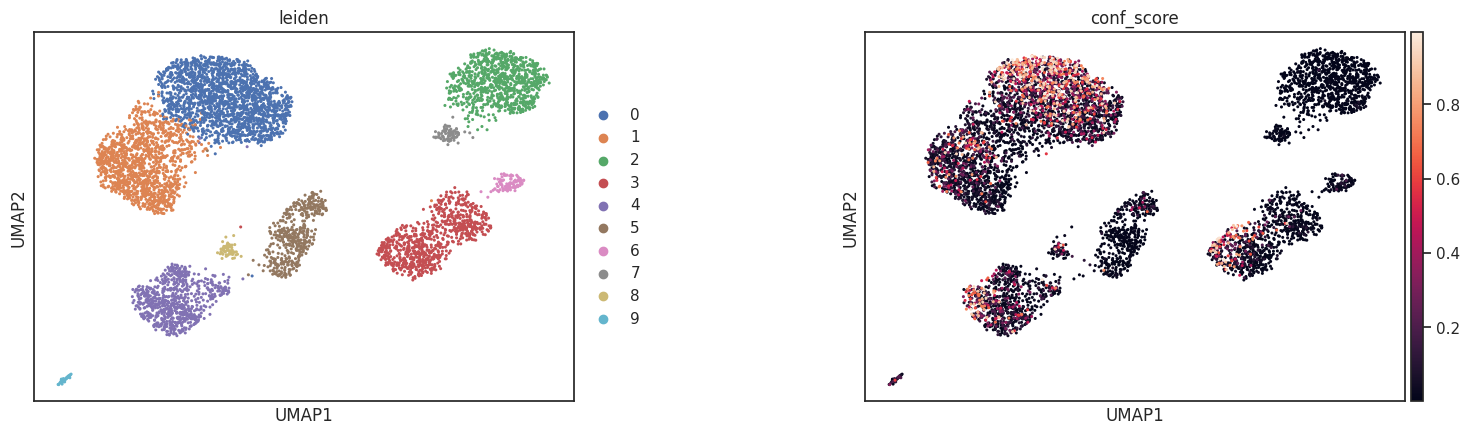

In [79]:
sc.pl.umap(predictions, color=["leiden", "conf_score"], wspace=0.4)

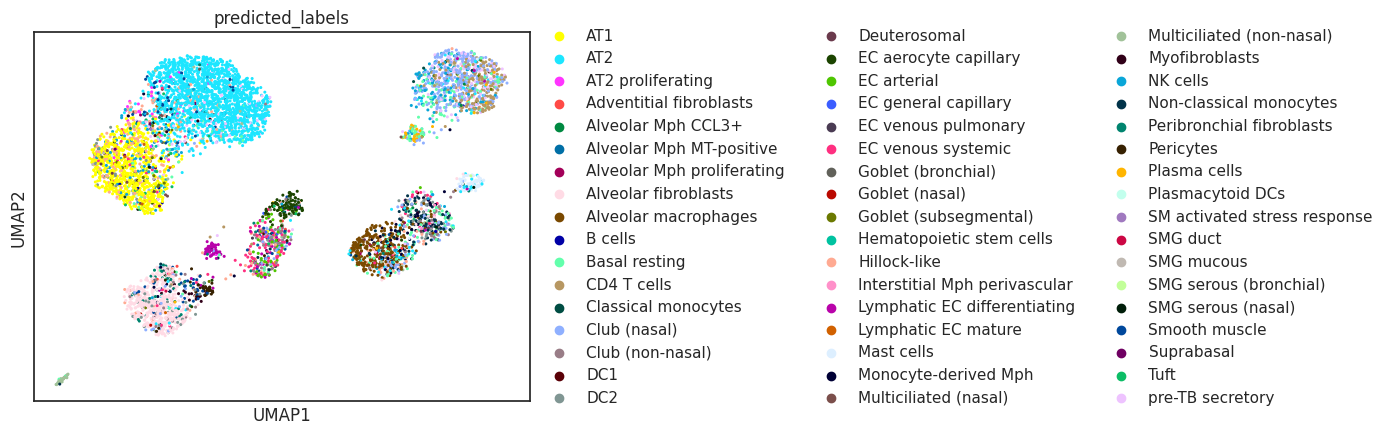

In [80]:
sc.pl.umap(predictions, color=["predicted_labels"])

Comparing leiden clusters with predicted labels

In [81]:
pd.crosstab(predictions.obs["leiden"], predictions.obs["predicted_labels"])


predicted_labels,AT1,AT2,AT2 proliferating,Adventitial fibroblasts,Alveolar Mph CCL3+,Alveolar Mph MT-positive,Alveolar Mph proliferating,Alveolar fibroblasts,Alveolar macrophages,B cells,...,Plasmacytoid DCs,SM activated stress response,SMG duct,SMG mucous,SMG serous (bronchial),SMG serous (nasal),Smooth muscle,Suprabasal,Tuft,pre-TB secretory
leiden,,,,,,,,,,,,,,,,,,,,,
0,6,1574,12,0,0,0,0,2,0,1,...,0,0,0,0,0,1,35,5,4,66
1,754,70,23,0,0,0,1,0,0,4,...,3,1,0,8,0,4,13,5,19,15
2,0,25,0,0,2,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,117
3,0,25,0,2,2,0,5,7,268,3,...,0,0,1,0,0,1,2,0,1,10
4,0,9,0,2,0,0,0,450,0,0,...,0,0,1,1,0,0,31,0,0,0
5,1,3,0,3,0,1,0,1,0,0,...,0,0,0,0,0,0,20,1,9,2
6,0,12,0,0,0,0,0,2,1,0,...,0,0,0,0,1,1,0,0,0,0
7,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
8,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [83]:
# Remove low-confidence predictions
predictions = predictions[predictions.obs["conf_score"] > 0.6, :]
# Or can be labelled as unknown
#predictions.obs.loc[predictions.obs["conf_score"] < 0.6, "predicted_labels"] = "unknown"

# Export to .h5ad

Refine metadata and remove unwanted cols

In [85]:
GSM5226575_GSM5226599_annotated = predictions.copy()
GSM5226575_GSM5226599_annotated.obs = GSM5226575_GSM5226599_annotated.obs[[
    "Sample", "leiden", "n_genes_by_counts",
    "total_counts", "pct_counts_mt",
    "predicted_labels", "conf_score"
]]

# Keeping original cluster annotations and predicted cluster annotations for comparison.

In [86]:
GSM5226575_GSM5226599_annotated.write("GSM5226575_GSM5226599_annotated.h5ad")

In [87]:
!ls

combined.h5ad			      integrated.h5ad
GSE171524_RAW			      PREDICTIONS_GSM5226575_GSM5226599.csv
GSM5226575_GSM5226599_annotated.h5ad  sample_data


Visualising cell type distribution

<Axes: xlabel='predicted_labels'>

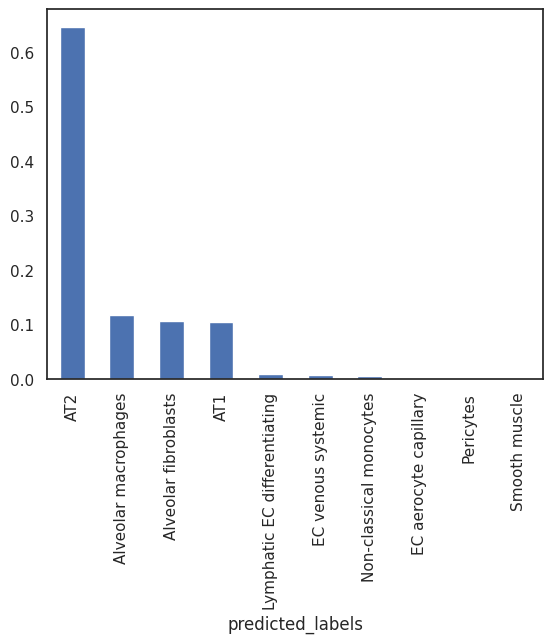

In [88]:
GSM5226575_GSM5226599_annotated.obs["predicted_labels"].value_counts(normalize=True).plot(kind="bar")


Checking UMAP for marker genes (test)

In [90]:
# sc.pl.umap(GSM5226575_GSM5226599_annotated, color=["INS", "GCG", "SST", "PPY"])
# Throws key error because this dataset does not contain marker genes

Future work: Marker genes can be identified.